<a href="https://colab.research.google.com/github/Lakshana002/Inception_v3/blob/main/Inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers

In [ ]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.17.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


In [ ]:
import os

# Assuming the files are already available in the directories
data_dir = '/content/drive/MyDrive/rice'  # Update this to the path where your data is stored
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

# Function to count the number of files in a directory and its subdirectories
def count(dir, counter=0):
    for pack in os.walk(dir):
        for f in pack[2]:  # The pack[2] contains the list of files in the current directory
            counter += 1
    return dir + " : " + str(counter) + " files"

# Print the total number of files in the train and validation folders
print('Total images for training:', count(train_dir))
print('Total images for validation:', count(validation_dir))


Total images for training: /content/drive/MyDrive/rice/train : 157 files
Total images for validation: /content/drive/MyDrive/rice/validation : 84 files


In [ ]:
import json

with open('/content/classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())

print (classes)

['Bacterial_leaf_blight', 'blast', 'brownspot']


In [ ]:
print('Number of classes:',len(classes))

Number of classes: 3


In [ ]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


In [ ]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 84 images belonging to 3 classes.
Found 157 images belonging to 3 classes.


In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(299, 299, 3), pooling='avg')
base_model.trainable = False  # Freeze the base model

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))

model.summary()




Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,853,411 (87.18 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # Changed 'lr' to 'learning_rate'
   loss='categorical_crossentropy',
   metrics=['accuracy'])


In [ ]:
import tensorflow as tf

EPOCHS=30 #@param {type:"integer"}

# Check if validation_generator has data
def train_generator_wrapper():
    for batch_x, batch_y in train_generator:
        yield batch_x, batch_y

def validation_generator_wrapper():
    for batch_x, batch_y in validation_generator:
        yield batch_x, batch_y

train_dataset = tf.data.Dataset.from_generator(
    train_generator_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None,) + IMAGE_SIZE + (3,), dtype=tf.float32),  # Specify the shape for images
        tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)  # Specify the shape for labels
    )
)
train_dataset = train_dataset.repeat()

validation_dataset = tf.data.Dataset.from_generator(
    validation_generator_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None,) + IMAGE_SIZE + (3,), dtype=tf.float32),  # Specify the shape for images
        tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)  # Specify the shape for labels
    )
)
validation_dataset = validation_dataset.repeat()

# When using these datasets in model.fit, you would then specify them directly
history = model.fit(
    train_dataset,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 53s 21s/step - accuracy: 0.5896 - loss: 0.8592 - val_accuracy: 0.1000 - val_loss: 3.7746
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 39s/step - accuracy: 0.7865 - loss: 0.6383 - val_accuracy: 0.6250 - val_loss: 0.9717
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 25s/step - accuracy: 0.8407 - loss: 0.3928 - val_accuracy: 0.1000 - val_loss: 5.9196
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 28s/step - accuracy: 0.7941 - loss: 0.6095 - val_accuracy: 0.6406 - val_loss: 0.8346
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 25s/step - accuracy: 0.8750 - loss: 0.3723 - val_accuracy: 0.4000 - val_loss: 2.3737
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 38s/step - accuracy: 0.8092 - loss: 0.3540 - val_accuracy: 0.5469 - val_loss: 1.7970
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 15s/step - accuracy: 0.8476 - loss: 0.5126 - val_accuracy: 0.1500 - val_loss: 5.4142
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 36s/step - accuracy: 0.8594 - loss: 0.4430 - val_accuracy: 0.7656 - val_loss: 0.6200


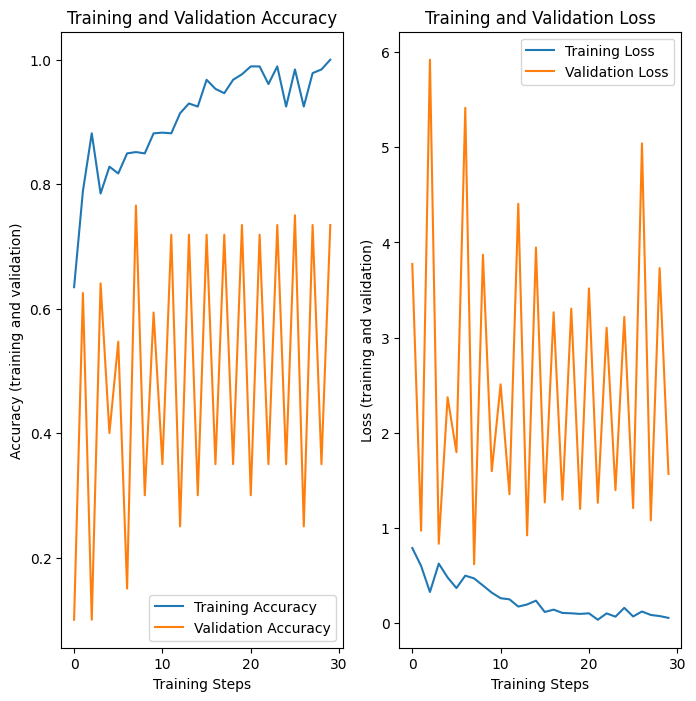

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255

    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: blast, file: blast/blast_rotated_024.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
PREDICTED: class: blast, confidence: 0.958339


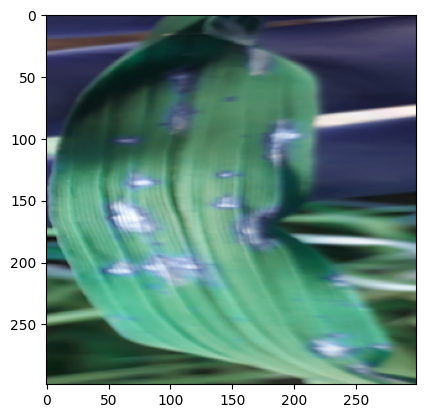

<Figure size 640x480 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_006.PNG
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.810512


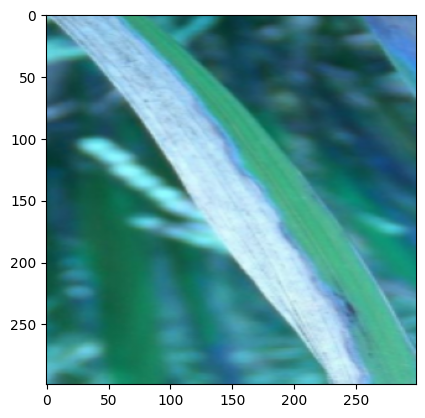

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_026.PNG
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.758522


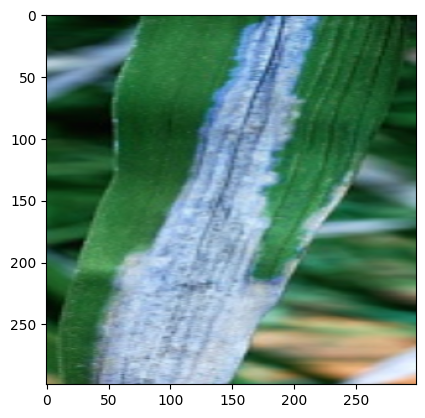

<Figure size 640x480 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.732671


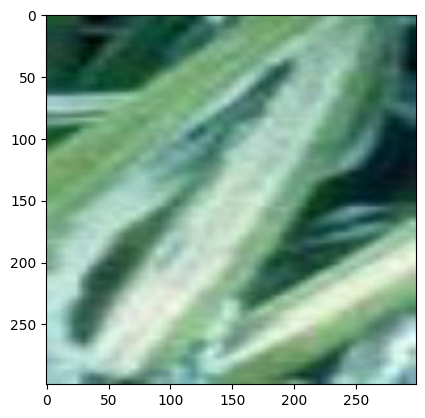

<Figure size 640x480 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.726913


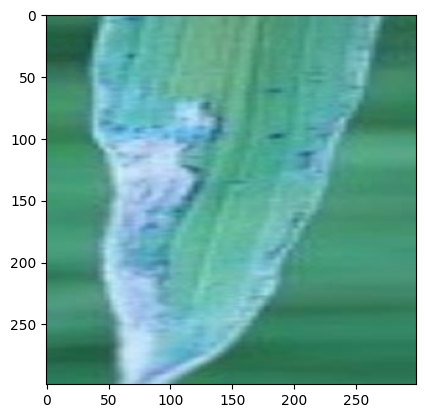

<Figure size 640x480 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()